#1.Setup Data
###1.1 import lib

In [159]:
import tensorflow as tf
import os

import cv2
import imghdr

import numpy as np
from matplotlib import pyplot as plt

###1.2 Load image

In [160]:
data_dir = '/content/data'
image_exts = ['jpeg','jpg','bmp','png']

In [161]:
#clear .ipynb_checkpoints
#!rmdir /content/data/.ipynb_checkpoints

In [162]:
for image_class in os.listdir(data_dir):
    print('Image Class {}', format(image_class))
    for image in os.listdir(os.path.join(data_dir,image_class)):
        image_path = os.path.join(data_dir,image_class,image)
        try:
          img = cv2.imread(image_path)
          tip = imghdr.what(image_path)
          if tip not in image_exts:
            print('Image not in ext list {}', format(image_path))
            os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

Image Class {} happy
Image Class {} sad


###1.3 Load data

In [163]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 305 files belonging to 2 classes.


In [164]:
data_iterator = data.as_numpy_iterator()

In [165]:
batch = data_iterator.next()

In [166]:
#Class 0 = Happy
#Class 1 = Sad
batch[1]

array([1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 1], dtype=int32)

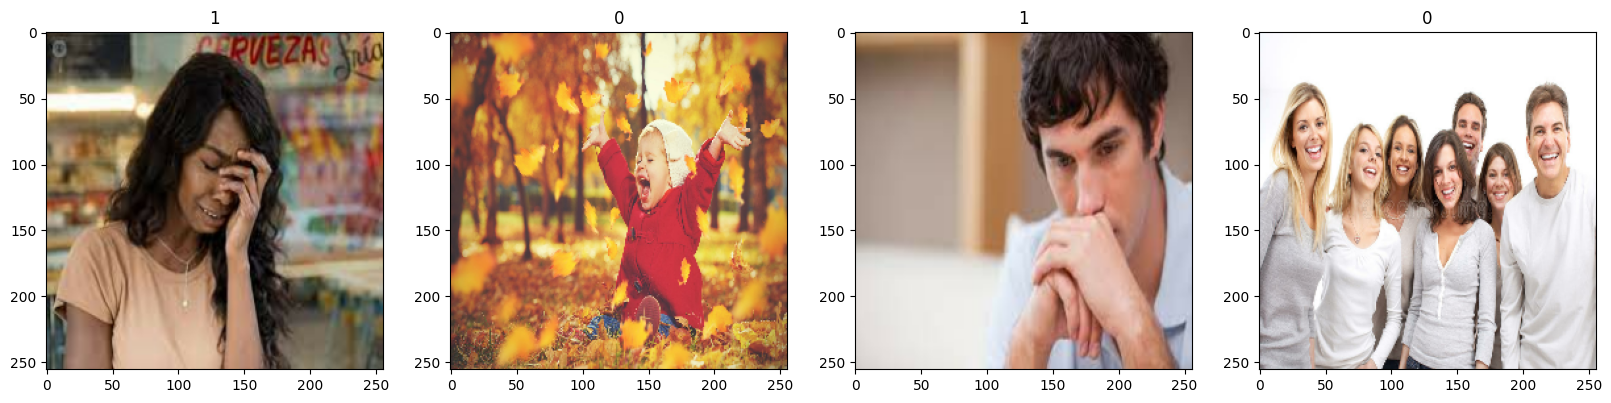

In [167]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

#2. Preprocess Data

###2.1 Scale Data

In [168]:
scaled_data = data.map(lambda x, y: (x/255,y))

In [169]:
scaled_iterator = scaled_data.as_numpy_iterator()

In [170]:
batch = scaled_iterator.next()

In [171]:
batch[0].min(), batch[0].max()

(0.0, 1.0)

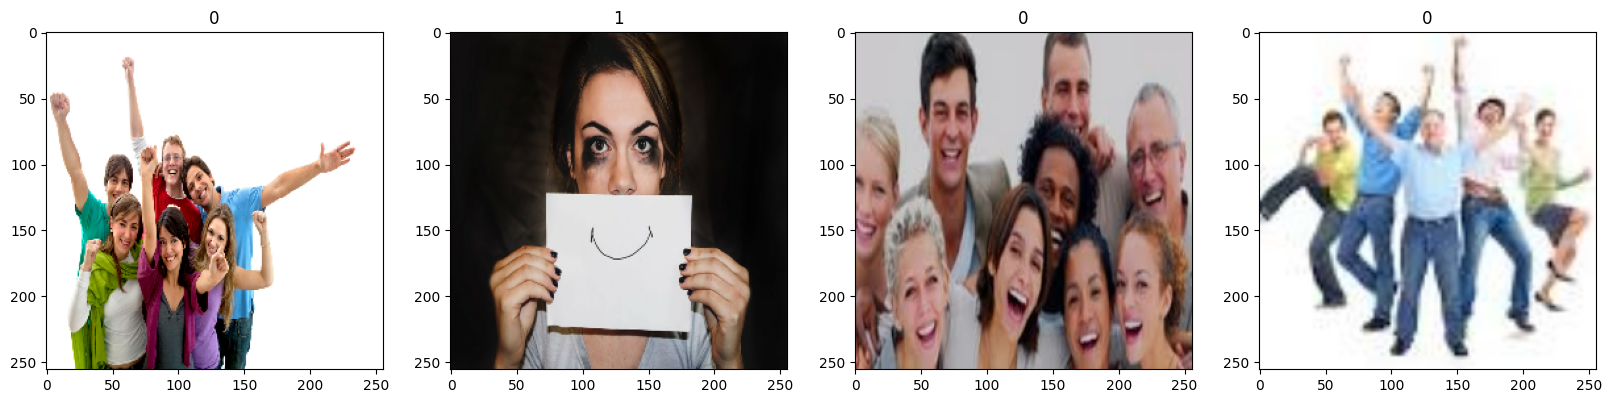

In [172]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

###2.2 Split Data

In [173]:
len(data)

10

In [174]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

train_size, val_size, test_size

(7, 2, 1)

In [175]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.take(train_size+val_size).take(test_size)

len(train), len(val), len(test),

(7, 2, 1)

#3.Deep Model
###3.1 Build Deep Learning Model

In [176]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

In [177]:
model = Sequential()

In [178]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPool2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [179]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [180]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 16)      

###3.2 Train

In [181]:
logdir='logs'

In [182]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [183]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 10s 495ms/step - loss: 228.2423 - accuracy: 0.4509 - val_loss: 9.0204 - val_accuracy: 0.4688
Epoch 2/20
7/7 [==============================] - 6s 549ms/step - loss: 5.0321 - accuracy: 0.5402 - val_loss: 0.6446 - val_accuracy: 0.5469
Epoch 3/20
7/7 [==============================] - 8s 909ms/step - loss: 0.5532 - accuracy: 0.6964 - val_loss: 0.4957 - val_accuracy: 0.7656
Epoch 4/20
7/7 [==============================] - 8s 905ms/step - loss: 0.4664 - accuracy: 0.7902 - val_loss: 0.2778 - val_accuracy: 0.9375
Epoch 5/20
7/7 [==============================] - 6s 475ms/step - loss: 0.3119 - accuracy: 0.8884 - val_loss: 0.2063 - val_accuracy: 0.9219
Epoch 6/20
7/7 [==============================] - 5s 475ms/step - loss: 0.1968 - accuracy: 0.9420 - val_loss: 0.1084 - val_accuracy: 0.9531
Epoch 7/20
7/7 [==============================] - 6s 509ms/step - loss: 0.0882 - accuracy: 0.9777 - val_loss: 0.0936 - val_accuracy: 0.9688
Epoch 8/20
7/7 [=

###3.3 Plot Performance

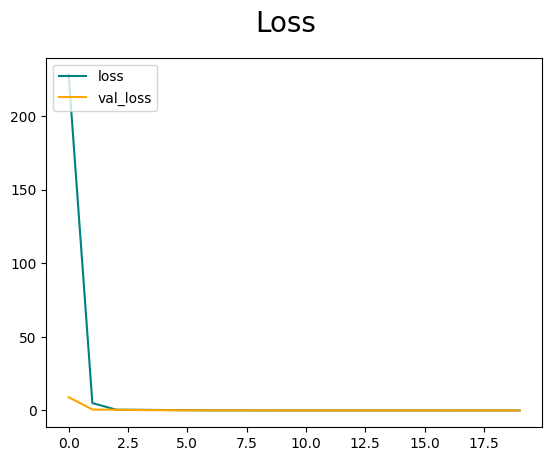

In [184]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

#4. Evaluate Performance
###4.1 Evaluate

In [185]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [186]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [187]:
len(test)

1

In [188]:
for batch in test.as_numpy_iterator():
    X,y   = batch
    yhat  = model.predict(X)
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    acc.update_state(y,yhat)

1/1 [==============================] - 0s 84ms/step


In [189]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


###4.2 Test

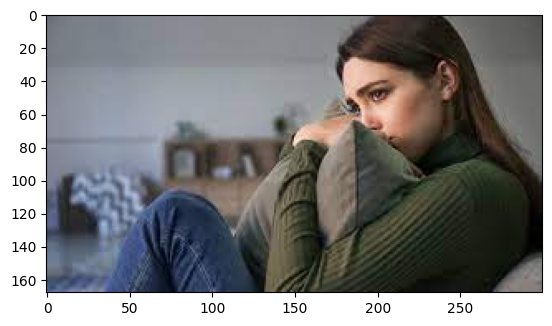

In [196]:
img = cv2.imread('/content/test/sad_test.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

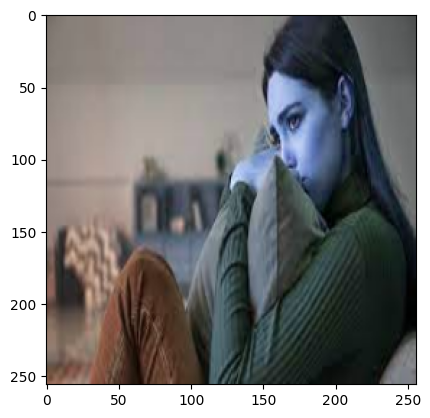

In [197]:
resize = tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [198]:
yhat = model.predict(np.expand_dims(resize/255,0))
yhat

1/1 [==============================] - 0s 19ms/step


In [200]:
if yhat > 0.5:
  print(f'Predicted class is Sad')
else:
  print(f'Predicted class is Happy')

Predicted class is Sad


#5. Save the Model
###5.1 Save the Model

In [153]:
from tensorflow.keras.models import load_model

In [154]:
model.save(os.path.join('models','happysadmodel.h5'))

#new_model = load_model(os.path.join('models','happysadmodel.h5'))